In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm.auto import tqdm
from collections import defaultdict
from qiskit.quantum_info import Clifford, Pauli
import jax

In [15]:
class LocalVQA:
    def __init__(self, num_qubits, num_layers):
        assert num_qubits % 2 == 0
        self.num_qubits = num_qubits
        self.num_layers = num_layers
    
    @property
    def num_parameters(self):
        return 2 * self.num_qubits * (self.num_layers + 1)
    
    def initial_gates(self, x, z):
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def entangling_layer(self, x, z, start=0):
        for n in range(start, self.num_qubits+start, 2):
            i = n % self.num_qubits
            j = (n +1 ) % self.num_qubits
            qml.CZ(wires=(i, j))
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def all_entangling_layers(self, x, z):
        s = 0
        for xi, zi in zip(x.reshape(self.num_layers, self.num_qubits), z.reshape(self.num_layers, self.num_qubits)):
            self.entangling_layer(xi, zi, start=s)
            s = 1-s
    
    def split_params(self, params):
        n = self.num_qubits
        x0 = params[:n]
        z0 = params[n: 2*n]
        
        num_x = len(params[2*n:]) // 2
        x = params[2*n: 2*n + num_x]
        z = params[2*n + num_x:]
        
        return x0, z0, x, z
        
    def circuit(self, params):
        x0, z0, x, z = self.split_params(params) 
        self.initial_gates(x0, z0)
        self.all_entangling_layers(x, z)
    
    def expval(self, pauli_string, params):
        
        obs = qml.pauli.string_to_pauli_word(pauli_string)
        dev = qml.device('default.qubit', wires=self.num_qubits)
        @qml.qnode(dev, interface='jax')
        def expectation():
            self.circuit(params)
            return qml.expval(obs)
        
        return expectation()
    
    def grad_expval(self, pauli_string, k, params):
        ek = np.zeros_like(params)
        ek[k] = 1
        
        f = lambda p: self.expval(pauli_string, params + np.pi / 2 * p)
        return (f(ek) - f(-ek)) / 2
        
    def hess_expval(self, pauli_string, k, l, params):
        ek = np.zeros_like(params)
        el = np.zeros_like(params)
        ek[k] = 1
        el[l] = 1
        f = lambda p: self.expval(pauli_string, params + np.pi / 2 * p)
        return (f(ek+el) - f(ek-el) - f(el-ek) + f(-ek-el)) / 4
    
    def random_parameters(self):
        return 2 * np.pi * np.random.uniform(size=self.num_parameters)
    
    def random_clifford_parameters(self):
        return np.pi / 2 * np.random.choice(range(4), size=self.num_parameters, replace=True) 
        
    def good_random_clifford_parameters(self, pauli_string):
        _, _, x, z = self.split_params(self.random_clifford_parameters())
        
        dev = qml.device('qiskit.aer', wires=range(self.num_qubits))
        @qml.qnode(dev)
        def circ(x, z):
            self.all_entangling_layers(x, z)
            return qml.expval(qml.Identity(wires=range(self.num_qubits)))
        
        circ(x, z)
        qc = dev._circuit
        qc.remove_final_measurements()
        
        entangled_pauli_string = Pauli(pauli_string[::-1]).evolve(Clifford(qc)).to_label()
 
        x0 = []
        z0 = []
        for p in entangled_pauli_string[::-1]:
            if p == 'I' or p == 'Z':
                x0.append(0)
                z0.append(0)
            if p == 'Y':
                x0.append(np.pi/2)
                z0.append(0)
            elif p == 'X':
                x0.append(np.pi/2)
                z0.append(np.pi/2)
        
        good_params = np.concatenate([x0, z0, x, z]) 
        assert np.allclose(np.abs(self.expval(pauli_string, good_params)), 1, atol=1e-5, rtol=1e-5)
        return good_params
    
    def draw(self):
        qml.draw_mpl(self.circuit)(*self.random_parameters())
        
def random_two_body_pauli(num_qubits):
    p1, p2 = np.random.choice(['X', 'Y', 'Z'], size=2, replace=True)
    i = np.random.choice(range(num_qubits-1))
    return 'I'*i + p1 + p2 + 'I'*(num_qubits-i-2)

In [16]:
def test_grads(num_qubits, num_layers):
    vqa = LocalVQA(num_qubits, num_layers)
    obs = random_two_body_pauli(vqa.num_qubits)
    
    p0 = vqa.random_parameters()
    f = lambda params: vqa.expval(obs, params)
    
    jax_grads = jax.grad(f)(p0)
    shift_grads = [vqa.grad_expval(obs, k, p0) for k in range(vqa.num_parameters)]
    
    jax_hess = jax.hessian(f)(p0)
    shift_hess = [[vqa.hess_expval(obs, k, l, p0) for k in range(vqa.num_parameters)] for l in range(vqa.num_parameters)]
    assert np.allclose(jax_grads, shift_grads, atol=1e-5, rtol=1e-5)
    assert np.allclose(jax_hess, shift_hess, atol=1e-5, rtol=1e-5)
    print('passed')

# test_grads(4, 2)

In [17]:
expvals = defaultdict(dict)

In [28]:
def plot_results():
    for n in expvals.keys():
        layers = list(expvals[n].keys())
        
        val_means = [np.abs(expvals[n][layer]['vals']).mean() for layer in layers] 
        grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
        hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]
        
        plt.scatter(layers, val_means)
        # plt.scatter(layers, grad_means, c='b')
        # plt.scatter(layers, hess_means, c='r')

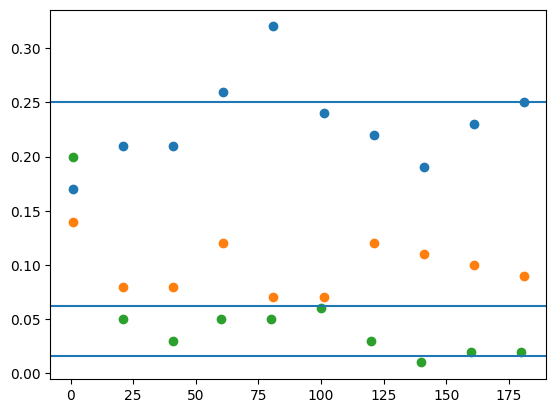

In [36]:
plot_results()
plt.axhline(2**-2)
plt.axhline(2**-4)
plt.axhline(2**-6)

In [19]:
def run_experiment(num_qubits, layers, num_obs, num_samples):
    
    for num_layers in tqdm(layers):
        vqa = LocalVQA(num_qubits, num_layers)
        
        vals = []
        grads = []
        hess = []
        for _ in range(num_obs):
            obs0 = random_two_body_pauli(vqa.num_qubits)
            phi = vqa.good_random_clifford_parameters(obs0)
            values0 = []
            grads0 = []
            hess0 = []
            for _ in range(num_samples // num_obs):
                obs1 = random_two_body_pauli(vqa.num_qubits)
                values0.append(vqa.expval(obs1, phi))
                
                k = np.random.choice(range(vqa.num_parameters))
                grads0.append(vqa.grad_expval(obs1, k, phi))
                              
                k, l = np.random.choice(range(vqa.num_parameters), size=2, replace=True)
                hess0.append(vqa.hess_expval(obs1, k, l, phi))
            
            vals.append(values0)
            grads.append(grads0)
            hess.append(hess0)
        
        expvals[num_qubits][int(num_layers)] = {'vals': np.array(vals), 'grads': np.array(grads), 'hess': np.array(hess)}
    return expvals

In [20]:
num_qubits = 2
layers = range(1, 200, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/10 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

In [21]:
num_qubits = 4
layers = range(1, 200, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/10 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

In [26]:
num_qubits = 6
layers = range(60, 200, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/7 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

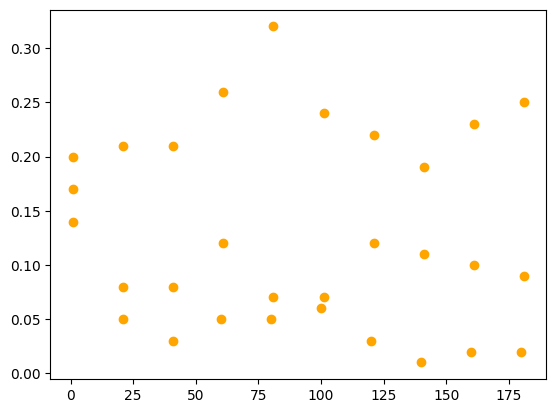

In [27]:
plot_results()